Processing folder: C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence\non_violence
Processing folder: C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence\violence
Training the CNN model...
Epoch 1/30


C:\Users\abhishik chebrolu\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


170/170 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.9830 - loss: 0.0480 - val_accuracy: 1.0000 - val_loss: 1.9702e-06 - learning_rate: 1.0000e-04
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 1.0000 - loss: 4.3163e-18 - val_accuracy: 1.0000 - val_loss: 3.7762e-07 - learning_rate: 1.0000e-04
Epoch 3/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 1.0000 - loss: 4.2474e-14 - val_accuracy: 1.0000 - val_loss: 8.2459e-13 - learning_rate: 1.0000e-04
Epoch 4/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 1.0000 - loss: 1.1100e-12 - val_accuracy: 1.0000 - val_loss: 5.5165e-17 - learning_rate: 1.0000e-04
Epoch 5/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 1.0000 - loss: 4.5331e-11 - val_accuracy: 1.0000 - val_loss: 2.1315e-19 - learning_rate: 2.0000e-05
Epoch 6/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 1.0000 - loss: 1.1025e-17 - val_accuracy: 1.0000 - val_loss: 5.3996e-20 - learning_rate: 2.0000e-05
Epoch 7/30
170/170 ━━━━━━

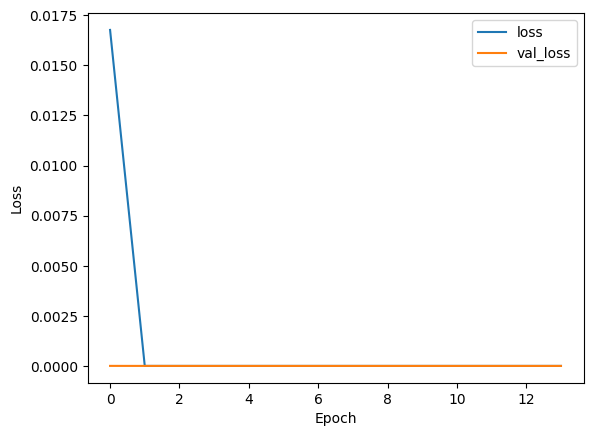

Testing the CNN model...
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to load the violence dataset (you need to adjust the path)
def load_violence_dataset(path):
    videos = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        print(f"Processing folder: {folder_path}")
        if os.path.isdir(folder_path):
            label = 1 if 'violence' in folder.lower() else 0  # 1: Violence, 0: Non-violence
            for file in os.listdir(folder_path):
                if file.endswith(('.jpg', '.png')):
                    image_path = os.path.join(folder_path, file)
                    try:
                        image = cv2.imread(image_path)
                        if image is None:
                            print(f"Failed to load image {image_path}. Skipping...")
                            continue

                        image = cv2.resize(image, (224, 224))  # Resize to the model input size
                        videos.append(image)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error processing image {image_path}: {e}")
                        continue
    videos = np.array(videos)
    labels = np.array(labels)
    return videos, labels

# Preprocess the dataset
def preprocess_data(images):
    images = images.astype('float32') / 255.0
    return images

# CNN Model
def create_cnn_model(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    output = Dense(1, activation='sigmoid')(x)  # Binary classification
    
    model = Model(input_img, output)
    return model

# Compile the model
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Data Augmentation
def augment_data(X_train, y_train):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )
    return datagen.flow(X_train, y_train, batch_size=32)

# Train the CNN model
def train_model(model, train_data, val_images, val_labels):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
    
    history = model.fit(train_data,
                        validation_data=(val_images, val_labels),
                        epochs=30,
                        callbacks=[early_stopping, lr_scheduler])
    return history

# Test the model and calculate performance metrics
def test_model(model, test_images, test_labels):
    preds = model.predict(test_images)
    preds = (preds > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(test_labels, preds)
    precision = precision_score(test_labels, preds)
    recall = recall_score(test_labels, preds)
    f1 = f1_score(test_labels, preds)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    return accuracy, precision, recall, f1

# Main function to execute the workflow
def main():
    dataset_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence'  # Update with the actual dataset path
    
    # Load the dataset and labels
    images, labels = load_violence_dataset(dataset_path)
    images = preprocess_data(images)
    
    # Split into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
    
    # Further split training data into training and validation sets (80% train, 20% validation)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)
    
    # Augment the training data
    train_data = augment_data(X_train, y_train)
    
    # Create and compile the CNN model
    input_shape = (224, 224, 3)
    model = create_cnn_model(input_shape)
    compile_model(model)
    
    # Train the CNN model
    print("Training the CNN model...")
    history = train_model(model, train_data, X_val, y_val)
    
    # Plot training history
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
    # Test the CNN model and calculate accuracy, precision, recall, F1
    print("Testing the CNN model...")
    accuracy, precision, recall, f1 = test_model(model, X_test, y_test)

if __name__ == "__main__":
    main()


Found 7752 images belonging to 2 classes.
Found 3321 images belonging to 2 classes.
Epoch 1/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 141s 577ms/step - accuracy: 0.5976 - loss: 0.6615 - val_accuracy: 0.6547 - val_loss: 0.6116 - learning_rate: 1.0000e-04
Epoch 2/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - accuracy: 0.6875 - loss: 0.6145 - val_accuracy: 0.6800 - val_loss: 0.6116 - learning_rate: 1.0000e-04
Epoch 3/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 108s 444ms/step - accuracy: 0.7387 - loss: 0.5267 - val_accuracy: 0.6930 - val_loss: 0.5831 - learning_rate: 1.0000e-04
Epoch 4/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.8125 - loss: 0.4596 - val_accuracy: 0.8400 - val_loss: 0.4518 - learning_rate: 1.0000e-04
Epoch 5/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 108s 443ms/step - accuracy: 0.7820 - loss: 0.4522 - val_accuracy: 0.6866 - val_loss: 0.5915 - learning_rate: 1.0000e-04
Epoch 6/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - accuracy: 0.7812 - loss: 0.5872 - val_accuracy: 0.7200 - val_los

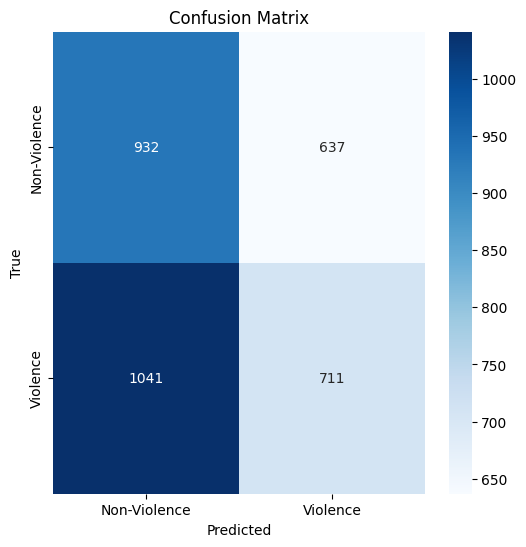

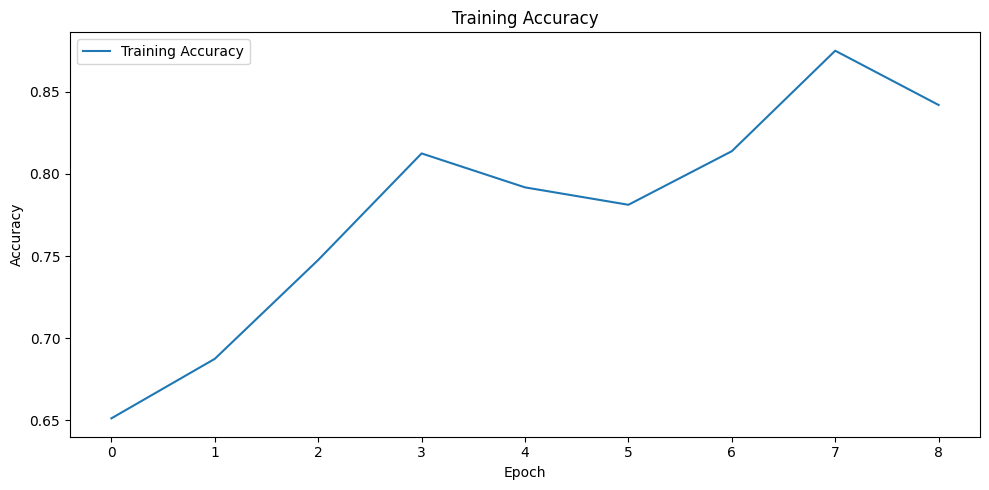

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a CNN Model for Classification
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Convolutional Layer Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Flatten()(x)
    
    # Dense layers for classification
    x = Dense(256, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create the model
    model = Model(inputs, outputs)
    
    return model

# Compile the CNN Model
def compile_cnn_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Test the model and calculate performance metrics
def test_cnn_model(model, test_generator):
    # Predict on the test set
    predictions = model.predict(test_generator)
    predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()
    
    # True labels (binary: 1 for violence, 0 for non-violence)
    true_labels = test_generator.classes
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Violence', 'Violence'], yticklabels=['Non-Violence', 'Violence'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return accuracy, precision, recall, f1

# Main function to execute workflow
def main():
    dataset_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence'  # Path to dataset
    input_shape = (224, 224, 3)

    # Create and compile the CNN model
    cnn_model = create_cnn_model(input_shape)
    compile_cnn_model(cnn_model)

    # Use ImageDataGenerator for data augmentation and data splitting
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        validation_split=0.3  # 70% training and 30% testing
    )

    batch_size = 32
    
    # Train and validation data generators
    train_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )
    
    val_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )

    # Calculate steps per epoch
    steps_per_epoch = max(train_generator.samples // batch_size, 1)
    validation_steps = max(val_generator.samples // batch_size, 1)

    # Early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    # Train the CNN model
    history = cnn_model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        epochs=15,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Evaluate the model on the test data
    print("Testing the CNN model...")
    test_accuracy, precision, recall, f1 = test_cnn_model(cnn_model, val_generator)

    # Plot training accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
